# Predicting Exchange Rates for US Dollar to Euro

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf
from pyramid.arima import auto_arima
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Exchange Rate Data
Exchange rate for US Dollars to Euros from the initial use of the Euro in January 2002 through August 2018 as found at https://www.federalreserve.gov/data.htm

In [4]:
# exchange rate data
USEU_raw = pd.read_csv('USD_EU.csv', header=5)

USEU_raw.head()

,Time Period,RXI$US_N.B.EU
0,2002-01-01,ND
1,2002-01-02,0.9031
2,2002-01-03,0.8992
3,2002-01-04,0.8946
4,2002-01-07,0.8931


In [9]:
USEU_data = USEU_raw

# convert index to datetime
USEU_data['Date'] = USEU_raw['Time Period']
USEU_data.index = pd.to_datetime(USEU_raw['Date'])

# Convert exchange rate to a number, with coersion to throw NAs if conversion not possible
USEU_data['Rate'] = pd.to_numeric(USEU_data['RXI$US_N.B.EU'], errors='coerce')

# drop original columns
USEU_data = USEU_data.drop(columns=['Time Period', 'RXI$US_N.B.EU', 'Date'])

# Remove NAs
USEU_data.dropna(inplace=True)

USEU_data.shape

(4189, 1)

In [10]:
USEU_data.head()

,Rate
Date,
2002-01-02,0.9031
2002-01-03,0.8992
2002-01-04,0.8946
2002-01-07,0.8931
2002-01-08,0.8925


In [11]:
USEU_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,4189.0,1.25222,0.141234,0.8594,1.1534,1.2684,1.3494,1.601


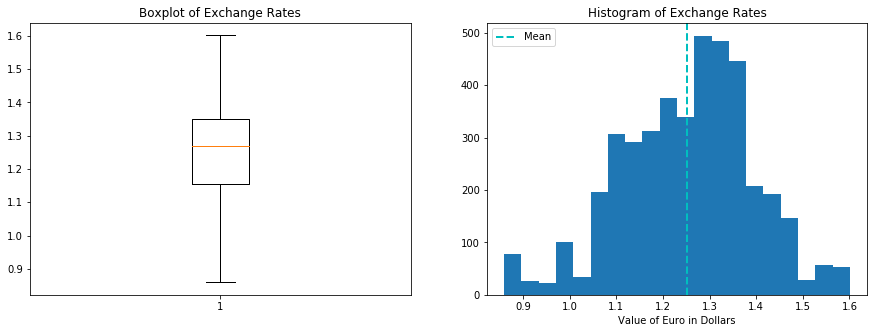

In [26]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(USEU_data.Rate.dropna(how = 'any'))
plt.title('Boxplot of Exchange Rates')

plt.subplot(1, 2, 2)
plt.xlabel('Value of Euro in Dollars')
plt.hist(USEU_data.Rate.dropna(how = 'any'), bins=20)
plt.axvline(USEU_data.Rate.mean(), color='c', linestyle='dashed', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Histogram of Exchange Rates')
plt.show()

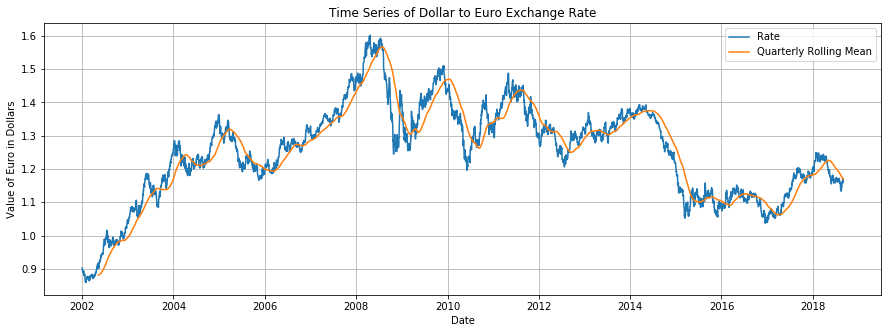

In [13]:
# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(USEU_data.index, USEU_data.Rate)
plt.plot(USEU_data.index, USEU_data.Rate.rolling(window=90,center=False).mean(), label = 'Quarterly Rolling Mean')
plt.grid(True)
plt.title('Time Series of Dollar to Euro Exchange Rate')
plt.legend()
plt.show()

The value of the euro generally increased from it's initial use in 2002 through 2008.  There are then erratic rates that generally trend down through 2015.  There is a significant drop in relative value of the Euro from late 2009 to mid 2010, then again from 2014 to early 2015. 

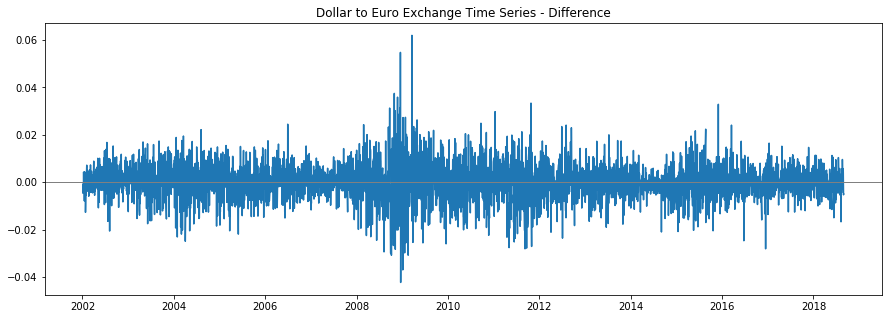

In [15]:
# difference from one record to next
USEU_data['diff_1'] = USEU_data.Rate - USEU_data.Rate.shift()

plt.figure(figsize=(15, 5))
plt.plot(USEU_data.index, USEU_data.diff_1)
plt.axhline(0, color='grey', linestyle='solid', linewidth=1)
plt.title('Dollar to Euro Exchange Time Series - Difference')
plt.show()

By plotting the difference from day to day we see greater volatility in the exchange rate in 2008 and 2009, with noticeable smaller extremes after 2009.  There is noticably more stability in the exchange rate in 2014 as less variation is seen from day to day.

### Training and Test
Separate data into train and test at 70/30 split.

In [23]:
train_size = int(len(USEU_data) * 0.7)
train, test = USEU_data[0:train_size], USEU_data[train_size:len(USEU_data)]
print('Observations: %d' % (len(USEU_data)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 4189
Training Observations: 2932
Testing Observations: 1257


In [39]:
test.head()

,Rate,diff_1
Date,,
2013-08-27,1.3387,0.0018
2013-08-28,1.3326,-0.0061
2013-08-29,1.3228,-0.0098
2013-08-30,1.3196,-0.0032
2013-09-03,1.3164,-0.0032


In [40]:
test.tail()

,Rate,diff_1
Date,,
2018-08-27,1.1676,0.0051
2018-08-28,1.1720,0.0044
2018-08-29,1.1699,-0.0021
2018-08-30,1.1646,-0.0053
2018-08-31,1.1596,-0.0050


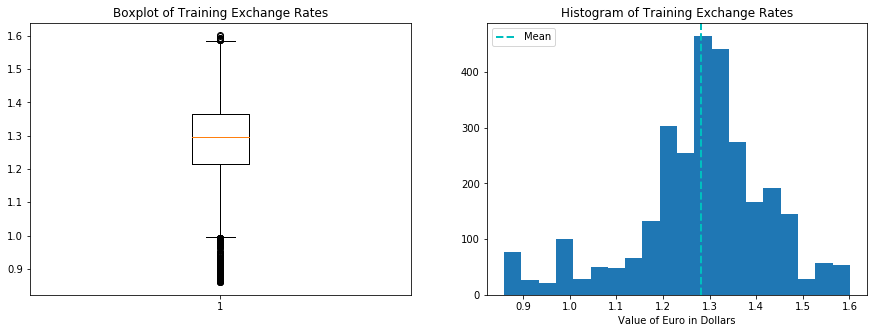

In [27]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(train.Rate.dropna(how = 'any'))
plt.title('Boxplot of Training Exchange Rates')

plt.subplot(1, 2, 2)
plt.xlabel('Value of Euro in Dollars')
plt.hist(train.Rate.dropna(how = 'any'), bins=20)
plt.axvline(train.Rate.mean(), color='c', linestyle='dashed', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Histogram of Training Exchange Rates')

plt.show()

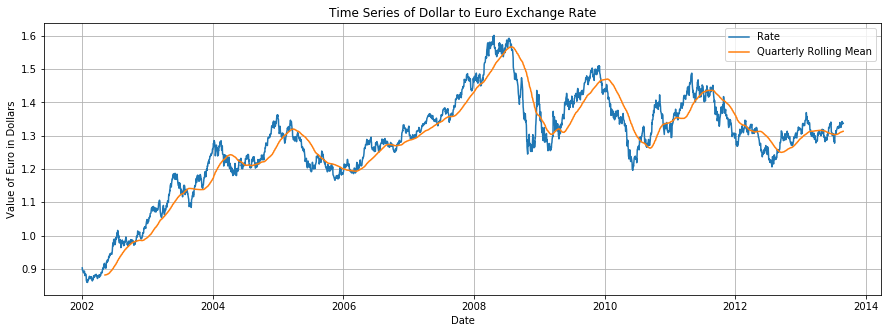

In [28]:
# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(train.index, train.Rate)
plt.plot(train.index, train.Rate.rolling(window=90,center=False).mean(), label = 'Quarterly Rolling Mean')
plt.grid(True)
plt.title('Time Series of Dollar to Euro Exchange Rate')
plt.legend()
plt.show()

# Time Series Models
The primary algorithm for time series is the ARIMA model.

## ARIMA model
Auto Regressive Moving Integrated Average<br>
Uses prior values, differences and prior errors to predict future values.

### Partial AutoCorrelation Function (PACF)
Comparing the exchange rate with a prior rate, testing for correlation - the values on the x-axis indicate the data shift.

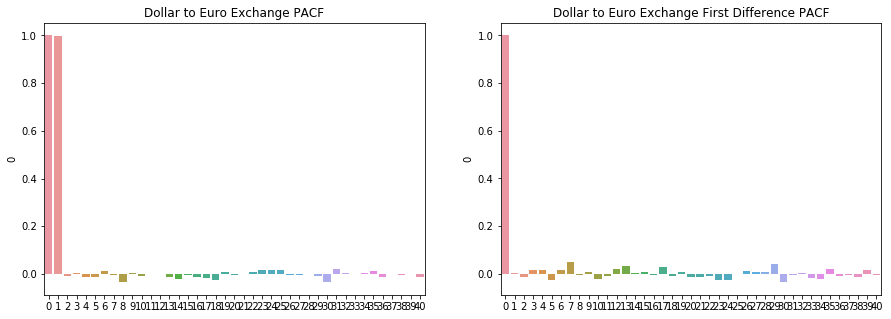

In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
x_pacf = pd.DataFrame(pacf(train.Rate))
sns.barplot(x=x_pacf.index, y=x_pacf[0])
plt.title("Dollar to Euro Exchange PACF")


plt.subplot(1, 2, 2)
x_pacf_diff = pd.DataFrame(pacf(train.diff_1[1:]))
sns.barplot(x=x_pacf_diff.index, y=x_pacf_diff[0])
plt.title("Dollar to Euro Exchange First Difference PACF")
plt.show()

Running a PACF of the original exchange rate values shows strong auto-correlation at 1.  The PACF of the exchange rate difference values shows no notable auto-correlation.

In [31]:
train_step_model = auto_arima(train.Rate, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(train_step_model.aic())

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=-19736.188, BIC=-19724.222, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-19734.202, BIC=-19716.253, Fit time=0.028 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-19734.203, BIC=-19716.253, Fit time=0.039 seconds
Total fit time: 0.417 seconds
-19736.18795990398


ARIMA model of (0,1,0) has the lowest AIC value.

In [37]:
# fit the model
model_010 = ARIMA(train.Rate, order=(0,1,0))
model_010_fit = model_010.fit()
print(model_010_fit.summary())
print('Residuals Description')
print(model_010_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rate   No. Observations:                 2931
Model:                 ARIMA(0, 1, 0)   Log Likelihood                9870.094
Method:                           css   S.D. of innovations              0.008
Date:                Thu, 13 Sep 2018   AIC                         -19736.188
Time:                        08:42:00   BIC                         -19724.222
Sample:                             1   HQIC                        -19731.879
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.961      0.337      -0.000       0.000
Residuals Description
count    2.931000e+03
mean     1.260109e-10
std      8.343676e-03
min     -4.244800e-02
25%     -4.248004e-03

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [45]:
# forecast
start_index = 2013-8-27
end_index = 2018-8-31
forecast = model_010_fit.predict(start=start_index, end=end_index)

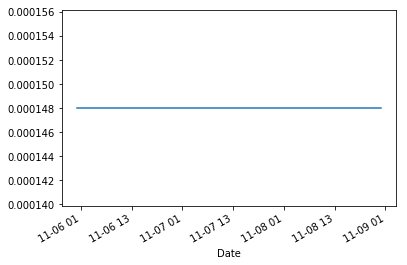

In [47]:
forecast.plot()